In [1]:
def set_jupyter_widescreen():
    from IPython.display import display, HTML
    
    display(HTML(data="""
    <style>
        div#notebook-container    {width: 95%; }
        div#menubar-container     {width: 65%; }
        div#maintoolbar-container {width: 99%; }
    </style>
    """))
set_jupyter_widescreen()

In [43]:
import os
import re
import time
import json
import openai
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv

import langchain.chat_models
import langchain.schema
from langchain.callbacks import get_openai_callback
from langchain import OpenAI

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

_ = load_dotenv(find_dotenv())

openai_api_key = os.environ["OPENAI_API_KEY"]

In [44]:
# setup LLM API access
llm = langchain.chat_models.ChatOpenAI(
    model_name="gpt-3.5-turbo", openai_api_key=openai_api_key
)

In [69]:
def gen_prompt(prompt: str, data_description:  str):
    prompt_template = """You are a Python programmer. Your job is to write Python code. Given a data set named `data`, please write Python code below to create a plot with matplotlib that satifies the following description: '{prompt}'.

Note: you can assume that `data` is an existing variable that can be used. {data_description}. Remember to assume that `data` is an existing variable that can be used, do reset the `data` variable. 

Python code (as markdown Python code block):"""
    return prompt_template.format(prompt=prompt, data_description=data_description)

In [70]:
prompt="""
Plot the data as time series plot between date and transaction amount. 
Show dates with their month name if they all have the same year.
Ensure the labels don't overlap. 
Mark transaction higher than 200000 with red star.
"""

# load the dataframe and add description
df = pd.read_excel("./data/ROBERT_KING.xlsx", index_col =0)
description = f"The dataframe has {df.shape[0]} rows and {df.shape[1]} columns. "
description += f"The columns are named {list(df.columns)}. "
description += f"The first 5 rows are: \n{df.head()}. "

In [71]:
full_prompt = gen_prompt(prompt=prompt, data_description=description)
with get_openai_callback() as cb:
    llm_response = llm([langchain.schema.HumanMessage(content=full_prompt)])
    print(cb)

Tokens Used: 760
	Prompt Tokens: 438
	Completion Tokens: 322
Successful Requests: 1
Total Cost (USD): $0.001301


In [83]:
print(full_prompt)

You are a Python programmer. Your job is to write Python code. Given a data set named `data`, please write Python code below to create a plot with matplotlib that satifies the following description: '
Plot the data as time series plot between date and transaction amount. 
Show dates with their month name if they all have the same year.
Ensure the labels don't overlap. 
Mark transaction higher than 200000 with red star.
'.

Note: you can assume that `data` is an existing variable that can be used. The dataframe has 100 rows and 6 columns. The columns are named ['Date', 'Account_Number', 'Transaction_Type', 'Transaction_Purpose', 'Transaction_Amount', 'Transaction_Description']. The first 5 rows are: 
         Date  Account_Number Transaction_Type Transaction_Purpose  \
0  2023-08-01      1012345678              ACH   Bills & utilities   
1  2023-08-01      1012345678         Transfer          Investment   
2  2023-08-02      1012345678       Debit Card        Food & drink   
3  2023-08-

In [82]:
print(llm_response.dict()['content'])

```python
import matplotlib.pyplot as plt
import pandas as pd

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Extract the month and year from the 'Date' column
data['Month'] = data['Date'].dt.month_name()
data['Year'] = data['Date'].dt.year

# Create a new column 'Label' to store the formatted date
data['Label'] = data['Date'].dt.strftime('%b %d, %Y')

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the data
plt.plot(data['Date'], data['Transaction_Amount'])

# Check if all the dates have the same year
if data['Year'].nunique() == 1:
    # Set the x-axis ticks to show month names
    plt.xticks(data['Date'].unique(), data['Month'].unique(), rotation=45)

# Add labels to the x-axis
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

# Check if any transaction amount is higher than 200000
if data['Transaction_Amount'].max() > 200000:
    # Mark the transactions higher than 200000 with red star
    plt.plot(data[data['Transaction_A

In [85]:
code = llm_response.content.split("```python")[1].split("```")[0]

In [87]:
print(code)


import matplotlib.pyplot as plt
import pandas as pd

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Extract the month and year from the 'Date' column
data['Month'] = data['Date'].dt.month_name()
data['Year'] = data['Date'].dt.year

# Create a new column 'Label' to store the formatted date
data['Label'] = data['Date'].dt.strftime('%b %d, %Y')

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the data
plt.plot(data['Date'], data['Transaction_Amount'])

# Check if all the dates have the same year
if data['Year'].nunique() == 1:
    # Set the x-axis ticks to show month names
    plt.xticks(data['Date'].unique(), data['Month'].unique(), rotation=45)

# Add labels to the x-axis
plt.xlabel('Date')
plt.ylabel('Transaction Amount')

# Check if any transaction amount is higher than 200000
if data['Transaction_Amount'].max() > 200000:
    # Mark the transactions higher than 200000 with red star
    plt.plot(data[data['Transaction_Amount'] >

ERROR:root:Error occurred while printing GeeksforGeeks
Traceback (most recent call last):
  File "/var/folders/lh/d77zc1bj4jnggnqtzj1r91k80000gn/T/ipykernel_75928/3589567761.py", line 6, in <module>
    exec(code, {"data": df, "fig": fig})
  File "<string>", line 24, in <module>
  File "/Volumes/develop/anaconda3/envs/llm/lib/python3.11/site-packages/matplotlib/pyplot.py", line 1824, in xticks
    labels = ax.set_xticklabels(labels, minor=minor, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Volumes/develop/anaconda3/envs/llm/lib/python3.11/site-packages/matplotlib/axes/_base.py", line 73, in wrapper
    return get_method(self)(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Volumes/develop/anaconda3/envs/llm/lib/python3.11/site-packages/matplotlib/axis.py", line 1968, in _set_ticklabels
    return self.set_ticklabels(labels, minor=minor, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Volumes/de

<Figure size 800x800 with 0 Axes>

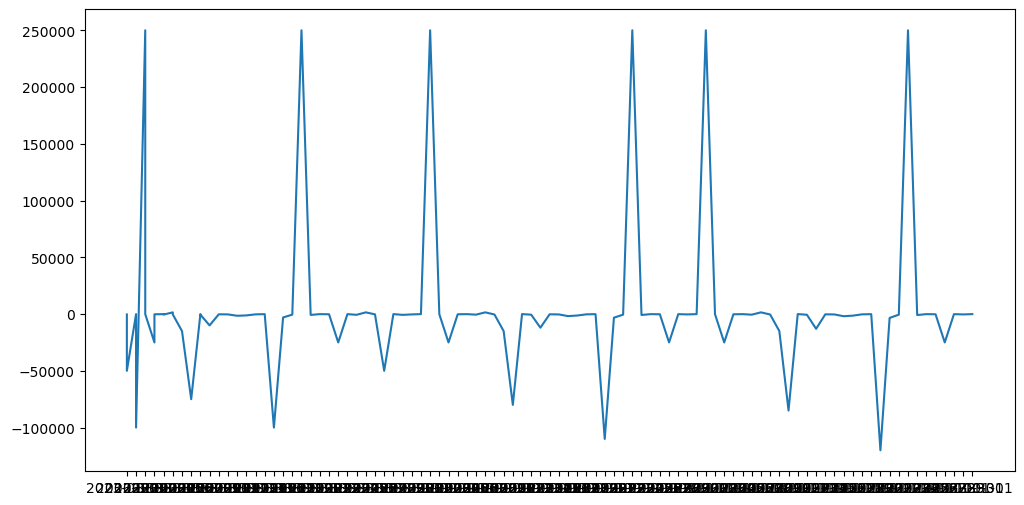

In [91]:
fig_args = {'figsize': (8,8)}
fig = plt.figure(**fig_args)

import logging
try:
    exec(code, {"data": df, "fig": fig})
except Exception as Argument: 
    logging.exception("Error occurred while printing GeeksforGeeks") 